Primero se debe instalar todas las librerías necesarias para leer y analizar los datos.

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install seaborn
# !pip install spacy
# !pip install nltk
# !pip install matplotlib
# ! python -m spacy download es_core_news_sm


Luego, importar las librerias instaladas.

In [2]:
import pandas as pd    
import spacy
import nltk 
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from spacy.lang.es.stop_words import STOP_WORDS
nlp = spacy.load("es_core_news_sm", disable=['ner', 'parser', 'tagger'])

Cargar los datos y realizar un respaldo en caso de pérdida.

In [3]:
dataset = pd.read_csv('datos.csv')
dataset_r = dataset.copy(deep=True) # respaldo

print('Cargando datos...')

dataset

Cargando datos...


,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin
0,B09G9BL5CP,India,11-08-2024,True,4,No charger,"Every thing is good about iPhones, there's not...",https://www.amazon.in/gp/customer-reviews/R345...,Reviewed in India on 11 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
1,B09G9BL5CP,India,16-08-2024,True,5,iPhone 13 256GB,"It look so fabulous, I am android user switche...",https://www.amazon.in/gp/customer-reviews/R2HJ...,Reviewed in India on 16 August 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
2,B09G9BL5CP,India,14-05-2024,True,4,Flip camera option nill,I tried to flip camera while recording but no ...,https://www.amazon.in/gp/customer-reviews/R3Y7...,Reviewed in India on 14 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
3,B09G9BL5CP,India,24-06-2024,True,5,Product,100% genuine,https://www.amazon.in/gp/customer-reviews/R1P9...,Reviewed in India on 24 June 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
4,B09G9BL5CP,India,18-05-2024,True,5,Good product,Happy to get the iPhone 13 in Amazon offer,https://www.amazon.in/gp/customer-reviews/R1XI...,Reviewed in India on 18 May 2024,Colour: MidnightSize: 256 GB,B09G9BQS98
...,...,...,...,...,...,...,...,...,...,...,...
3057,B09G9D8KRQ,India,11-10-2023,True,1,Very bad experience with i phone 13,Useless phon never buy this heat n useless cam...,https://www.amazon.in/gp/customer-reviews/R10O...,Reviewed in India on 11 October 2023,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N
3058,B09G9D8KRQ,India,14-10-2022,True,2,not happy with this apple product,iam not happy with this product why because ch...,https://www.amazon.in/gp/customer-reviews/R2FW...,Reviewed in India on 14 October 2022,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N
3059,B09G9D8KRQ,India,24-02-2022,True,3,Good phone,Good phone,https://www.amazon.in/gp/customer-reviews/R2C7...,Reviewed in India on 24 February 2022,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N
3060,B09G9D8KRQ,India,16-10-2023,True,1,Battery discharge,While charging mobile it's getting so hot even...,https://www.amazon.in/gp/customer-reviews/R3K0...,Reviewed in India on 16 October 2023,Colour: (PRODUCT) REDSize: 128 GB,B09G99CW2N


Graficar la distribución de puntajes.

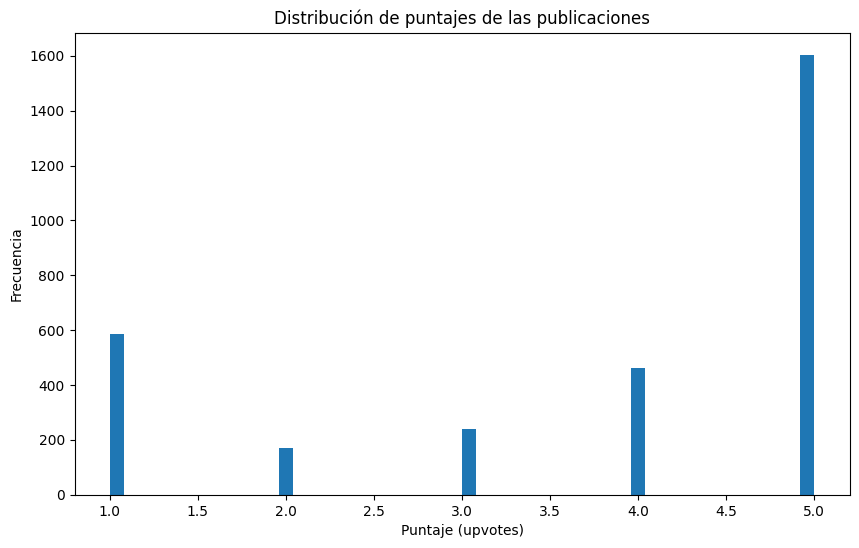

In [4]:
plt.figure(figsize=(10,6))
dataset['ratingScore'].plot(kind='hist', bins=50)
plt.title('Distribución de puntajes de las publicaciones')
plt.xlabel('Puntaje (upvotes)')
plt.ylabel('Frecuencia')
plt.show()


Se puede ver que existen una gran cantidad de respuestas positivas sobre el equipo. Sin embargo, también se puede apreciar una cantidad no menor de respuestas negativas al equipo.

In [5]:

tamanos_subcategorias = dataset.groupby('ratingScore').size()

# Crear un DataFrame con las subcategorías y sus tamaños
dataset_subset = pd.DataFrame({
    'Subcategoría': tamanos_subcategorias.index,
    'Tamaño': tamanos_subcategorias.values
})

# Mostrar el DataFrame
dataset_subset

,Subcategoría,Tamaño
0,1,587
1,2,171
2,3,239
3,4,461
4,5,1604


In [6]:


min_samples = dataset_subset['Tamaño'].min()

print(f"El número mínimo de ejemplos entre las subcategorías es: {min_samples}")

g = dataset.groupby('ratingScore')

dataset_balanceado = g.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


print(f"Tamaño del dataset balanceado: {len(dataset_balanceado)}")
print("Tamaño por subcategoría después del balanceo:")
print(dataset_balanceado.groupby('ratingScore').size())

dataset_balanceado

El número mínimo de ejemplos entre las subcategorías es: 171
Tamaño del dataset balanceado: 855
Tamaño por subcategoría después del balanceo:
ratingScore
1    171
2    171
3    171
4    171
5    171
dtype: int64


/tmp/ipykernel_72519/1001277432.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset_balanceado = g.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


,productAsin,country,date,isVerified,ratingScore,reviewTitle,reviewDescription,reviewUrl,reviewedIn,variant,variantAsin
0,B0BN72MLT2,United States,21-10-2023,True,1,Buyers beware!,This phone came with a defect with the camera....,https://www.amazon.com/gp/customer-reviews/R1C...,"Reviewed in the United States on October 21, 2023",Service Provider: UnlockedColor: MidnightSize:...,B0BN72MLT2
1,B09G9D8KRQ,India,17-10-2021,False,1,Apple is trying to loot people,You have to pay 95000+ for this stupid phone w...,https://www.amazon.in/gp/customer-reviews/RABT...,Reviewed in India on 17 October 2021,Colour: BlueSize: 256 GB,B09G93H3BR
2,B09G9D8KRQ,India,14-04-2024,True,1,Worst Product. Extremely bad customer service,Pathetic experience... Unable to hear any soun...,https://www.amazon.in/gp/customer-reviews/R1KN...,Reviewed in India on 14 April 2024,Colour: StarlightSize: 128 GB,B09G9D8KRQ
3,B0BN72MLT2,United States,13-02-2024,True,1,Mobile defects,I purchase this mobile on May 2022 and it is w...,https://www.amazon.com/gp/customer-reviews/R26...,"Reviewed in the United States on February 13, ...",Service Provider: UnlockedColor: BlueSize: 256GB,B0BN71T1J7
4,B0BDK8LKPJ,India,31-03-2023,True,1,Heating issues,Heating issues .thought it will be ok in a day...,https://www.amazon.in/gp/customer-reviews/R2N9...,Reviewed in India on 31 March 2023,Colour: StarlightSize: 128 GB,B0BDK8LKPJ
...,...,...,...,...,...,...,...,...,...,...,...
850,B09G9D8KRQ,India,10-06-2022,True,5,Worth it,NaN,https://www.amazon.in/gp/customer-reviews/R2ZZ...,Reviewed in India on 10 June 2022,Colour: BlueSize: 256 GB,B09G93H3BR
851,B0BN72MLT2,United States,17-05-2024,True,5,Iphone14,I LOVE IT SM EXACTLY LIKS U THINK IT IS I reco...,https://www.amazon.com/gp/customer-reviews/R2V...,"Reviewed in the United States on May 17, 2024",Service Provider: UnlockedColor: PurpleSize: 1...,B0BN71VW28
852,B0BN72MLT2,United States,09-10-2023,True,5,Maravilloso!,Todo excelente!!,https://www.amazon.com/gp/customer-reviews/R2U...,"Reviewed in the United States on October 9, 2023",Service Provider: UnlockedColor: BlueSize: 256GB,B0BN71T1J7
853,B0BDK8LKPJ,India,18-10-2023,True,5,Android to Apple Transition - Not a smooth exp...,Always feels good to hold this masterpiece. Th...,https://www.amazon.in/gp/customer-reviews/R3GE...,Reviewed in India on 18 October 2023,Colour: BlueSize: 128 GB,B0BDK62PDX


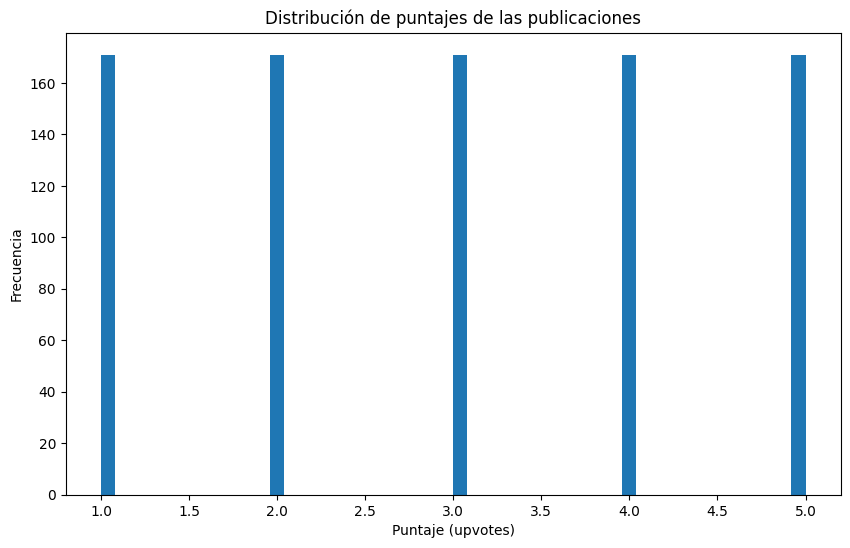

In [7]:

# Graficar la distribución de puntajes
plt.figure(figsize=(10,6))
dataset_balanceado['ratingScore'].plot(kind='hist', bins=50)
plt.title('Distribución de puntajes de las publicaciones')
plt.xlabel('Puntaje (upvotes)')
plt.ylabel('Frecuencia')
plt.show()


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_balanceado.reviewDescription,
    dataset_balanceado.ratingScore,
    test_size=0.33,
    random_state=42,
)


In [9]:
X_train

781    very much satisfied with phone.... everything ...
56     Don’t buy any one this is device is getting ve...
291     Feature are good ,colour is not according to. Me
316    Wifi issue after 6-7 months, wifi remains conn...
842                                    Best in the range
                             ...                        
71              touch is very poor, not working properly
106    This phone is locked!!  I can not use it on an...
270    Everything about this iphone is good axcept ba...
435    The phone is actually pretty good but it had s...
102    When I opened the box 1 very small dent was ob...
Name: reviewDescription, Length: 572, dtype: object

In [10]:
X_test

66     No me deja poner el iCloud en el celular, dice...
434    The phone heats a lot while using even for bas...
198                                                 Good
212    There was a very noticeable scratch on the sid...
793    Great phone , loved it and the camera quality ...
                             ...                        
670    Except some few scratches, it is a very good m...
815                   NYC looking  amazing  good service
41     No biometrics with many UI flaws. Too expensiv...
528    Design:The iPhone 13 retains the classic Apple...
108                                           Very worst
Name: reviewDescription, Length: 283, dtype: object

In [11]:
# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer()  

# Definimos el clasificador que usaremos.
clf = MultinomialNB()   

# Creamos el pipeline
text_clf = Pipeline([('vect', vectorizer), ('clf', clf)])

In [12]:
# Fill NaN values in the reviewDescription column
X_train = X_train.fillna('')

# Fit the model
text_clf.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

In [13]:
X_test = X_test.fillna('')

y_pred = text_clf.predict(X_test)
y_pred

array([1, 2, 5, 3, 5, 3, 5, 3, 1, 5, 4, 3, 1, 3, 1, 4, 3, 1, 4, 4, 2, 3,
       4, 5, 4, 5, 5, 5, 4, 4, 5, 3, 1, 4, 5, 3, 1, 5, 1, 5, 1, 5, 3, 1,
       3, 1, 3, 3, 3, 5, 3, 4, 1, 1, 3, 3, 2, 4, 1, 5, 1, 3, 3, 3, 5, 1,
       1, 5, 3, 1, 1, 1, 2, 1, 5, 3, 3, 2, 1, 1, 5, 1, 2, 2, 3, 2, 3, 3,
       2, 1, 2, 3, 3, 2, 2, 3, 5, 5, 5, 2, 3, 5, 5, 1, 2, 2, 2, 5, 1, 5,
       3, 2, 3, 2, 3, 2, 4, 3, 1, 3, 3, 3, 2, 3, 5, 5, 2, 3, 1, 1, 3, 1,
       1, 5, 2, 4, 2, 5, 1, 2, 4, 2, 2, 1, 2, 2, 1, 5, 5, 2, 1, 1, 4, 1,
       2, 4, 3, 3, 3, 3, 5, 3, 5, 5, 1, 2, 1, 1, 1, 1, 5, 3, 1, 3, 5, 2,
       4, 1, 2, 1, 4, 2, 4, 3, 5, 3, 2, 3, 5, 1, 2, 3, 5, 1, 1, 5, 2, 5,
       3, 3, 5, 5, 3, 1, 3, 2, 1, 3, 5, 3, 5, 5, 1, 1, 1, 2, 2, 2, 1, 2,
       2, 5, 4, 3, 1, 3, 5, 4, 4, 3, 3, 2, 3, 2, 2, 5, 2, 2, 5, 5, 1, 1,
       1, 1, 3, 1, 3, 2, 3, 2, 5, 2, 3, 3, 1, 1, 1, 5, 2, 3, 2, 3, 1, 2,
       1, 2, 3, 1, 5, 5, 5, 2, 1, 2, 4, 3, 4, 3, 3, 5, 1, 4, 1])

In [14]:
pd.DataFrame({'content': X_test, 'category':y_test, 'predicted category': y_pred})

,content,category,predicted category
66,"No me deja poner el iCloud en el celular, dice...",1,1
434,The phone heats a lot while using even for bas...,3,2
198,Good,2,5
212,There was a very noticeable scratch on the sid...,2,3
793,"Great phone , loved it and the camera quality ...",5,5
...,...,...,...
670,"Except some few scratches, it is a very good m...",4,3
815,NYC looking amazing good service,5,5
41,No biometrics with many UI flaws. Too expensiv...,1,1
528,Design:The iPhone 13 retains the classic Apple...,4,4


In [15]:
# usando la matriz de confusión:

# eje x -> predichos
# eje y -> clase real

print(confusion_matrix(y_test, y_pred))

[[37  9  8  1  3]
 [16 20  9  3  7]
 [10 14 27  5  7]
 [ 4  9 18 11 16]
 [ 3  5 11  5 25]]


In [16]:
# usando el classification report:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.53      0.64      0.58        58
           2       0.35      0.36      0.36        55
           3       0.37      0.43      0.40        63
           4       0.44      0.19      0.27        58
           5       0.43      0.51      0.47        49

    accuracy                           0.42       283
   macro avg       0.42      0.43      0.41       283
weighted avg       0.42      0.42      0.41       283



In [17]:
text_clf.predict([
    ("Super")
])


array([4])

In [18]:
text_clf.predict([
    ("bad")
])

array([2])

In [19]:
text_clf.predict([
    ("good but broke")
])

array([2])

In [20]:
text_clf.predict([
    ("it is so so")
])

array([3])

In [21]:
# Tokenizers para CountVectorizer

# Solo tokenizar el doc usando spacy.
def tokenizer(doc):
    return [x.orth_ for x in nlp(doc)]


# Tokenizar y remover las stopwords del doc
def tokenizer_with_stopwords(doc):
    return [x.orth_ for x in nlp(doc) if x.orth_ not in STOP_WORDS]


# Tokenizar y lematizar.
def tokenizer_with_lemmatization(doc):
    return [x.lemma_ for x in nlp(doc)]

# Tokenizar y hacer stemming.
def tokenizer_with_stemming(doc):
    stemmer = SnowballStemmer('spanish')
    return [stemmer.stem(word) for word in [x.orth_ for x in nlp(doc)]]

In [22]:
TOKENIZER = tokenizer_with_stemming

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=TOKENIZER,
                             ngram_range=(1, 1))

# Definimos el clasificador que usaremos.
clf = MultinomialNB()   

# Creamos el pipeline
text_clf_2 = Pipeline([('vect', vectorizer), ('clf', clf)])

In [23]:
text_clf_2.fit(X_train, y_train)
y_pred = text_clf_2.predict(X_test)

/home/carl/Proyectos/ing-datos/mp3/.entorno/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [24]:
# usando la matriz de confusión:
print(confusion_matrix(y_test, y_pred),
      '\n\n-------------------------------------------------------\n')
# usando el classification report:
print(classification_report(y_test, y_pred))

[[34  9  9  2  4]
 [14 21 11  2  7]
 [12 16 21  6  8]
 [ 3  9 18 13 15]
 [ 3  5 11  6 24]] 

-------------------------------------------------------

              precision    recall  f1-score   support

           1       0.52      0.59      0.55        58
           2       0.35      0.38      0.37        55
           3       0.30      0.33      0.32        63
           4       0.45      0.22      0.30        58
           5       0.41      0.49      0.45        49

    accuracy                           0.40       283
   macro avg       0.41      0.40      0.40       283
weighted avg       0.40      0.40      0.39       283



In [25]:
# Qué tokenizer usaremos?
TOKENIZER = tokenizer_with_lemmatization

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=TOKENIZER,
                             ngram_range=(1, 1))

# Ahora definimos regresión logística como clasificador.
log_mod = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter = 1000)   
log_pipe = Pipeline([('vect', vectorizer), ('clf', log_mod)])

In [26]:
log_pipe.fit(X_train, y_train)
y_pred = log_pipe.predict(X_test)

/home/carl/Proyectos/ing-datos/mp3/.entorno/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/carl/Proyectos/ing-datos/mp3/.entorno/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [27]:
# usando la matriz de confusión:
print(confusion_matrix(y_test, y_pred),
      '\n\n-------------------------------------------------------\n')
# usando el classification report:
print(classification_report(y_test, y_pred))

[[23  8  9 15  3]
 [ 4 20 11  9 11]
 [11 12 15 17  8]
 [ 2  5 10 28 13]
 [ 3  6  3 11 26]] 

-------------------------------------------------------

              precision    recall  f1-score   support

           1       0.53      0.40      0.46        58
           2       0.39      0.36      0.38        55
           3       0.31      0.24      0.27        63
           4       0.35      0.48      0.41        58
           5       0.43      0.53      0.47        49

    accuracy                           0.40       283
   macro avg       0.40      0.40      0.40       283
weighted avg       0.40      0.40      0.39       283



In [28]:
# Qué tokenizer usaremos?
TOKENIZER = tokenizer_with_lemmatization

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=TOKENIZER,
                             ngram_range=(1, 3))

# Ahora definimos regresión logística como clasificador.
log_mod = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter = 1000)   
log_pipe = Pipeline([('vect', vectorizer), ('clf', log_mod)])

In [29]:
# usando la matriz de confusión:
print(confusion_matrix(y_test, y_pred),
      '\n\n-------------------------------------------------------\n')
# usando el classification report:
print(classification_report(y_test, y_pred))

[[23  8  9 15  3]
 [ 4 20 11  9 11]
 [11 12 15 17  8]
 [ 2  5 10 28 13]
 [ 3  6  3 11 26]] 

-------------------------------------------------------

              precision    recall  f1-score   support

           1       0.53      0.40      0.46        58
           2       0.39      0.36      0.38        55
           3       0.31      0.24      0.27        63
           4       0.35      0.48      0.41        58
           5       0.43      0.53      0.47        49

    accuracy                           0.40       283
   macro avg       0.40      0.40      0.40       283
weighted avg       0.40      0.40      0.39       283

